# Basic Introduction to Particle Filters : Updating and Sampling

The Kalman Filter can only model Gaussian Distributions. The Particle filter is an approach for dealing with arbitrary distributions, and it uses multiple random samples to represent them.

To represent a PDF using samples, we can take more samples in areas were values are higher. A more "lightweight" approach is to weight those samples of higher value areas, so that we require less samples.

# The particle set

Every sample has two variables:

$X = \langle x^{[j]}, w^{[j]} \rangle_{j = 1,...,J} $

with $w^{[j]}$ the importance weight (a real number), and $x^{[j]}$ the state hypothesis (a vector).


The samples represent the posterior:

$p(x) = \sum^J_{j=1}w^{[j]}\delta_{x^{[j]}}(x)$

With sum up to one. Depending how complex the function to represent is, there could be a larger amount of samples.
How do we obtain the samples?


# Particle filter for dynamic state estimation problems
The particle filter is a recursive Bayes filter. It is a non-parametric approach, because models the distribution by taking samples. The recursive steps can be sumed up as:
- Prediction: draw from a proposal distribution $\pi$ to generate the samples from $f$. The proposal is a used-defined choice, so it could be, for instance, the odometry model.
- Correction: weighting by the ratio of target and proposal. It is not a user-defined choice. It accounts the difference between $\pi$ and $f$ using a weight $w = f(x)/\pi(x)$.
- Resampling: Draw a sample $i$ with a probability $w_t^{[i]}$ and repeat. $J$ times. The higher the weight of a sample is, the more probability of sampling in the next step. This way, we replace the weights by frequencies.

# Monte Carlo localization

With Monte Carlo localization with estimate the position and orientation of a platform using a particle filter.

- Each particle is a pose hypothesis.
- The proposal is the motion model.
- The correction is performed via the observation model.

## Resampling

For resampling, stochastic universal resampling is faster and better since it has a low variance. It works in case of having identical weights for all samples.

# Cons
The particle filters need to represent the space of possibilities in a efficient manner, and because of that it is:
- Problematic in high dimensional spaces.
- Problematic in situations with high uncertainty.

Any of those two cases would make the dimensionality of the state space grow exponentially.

# Pros

- Works in non-Gaussian distributions.
- Works well in low-dimensional spaces
- Handles data association ambiguities
- Easily incorporates different sensing modalities.
- Comparably robust when the model is not perfect and suboptimal setups.
- Easy to implement

# Variants
- Real time particle filters to handle situations with sensor data coming at different rates
- Delayed state particle filters, when some of the streams come very late and need to be re-synchronized
- Rao-Blackwellized particle filters for dealing with high dimensional state spaces.

Finally, as stated by Cyrill Stachniss in his course:

# THE ART IS TO DESIGN APPROPIATE MOTION AND SENSOR MODELS



In [1]:
!pip install celluloid

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML
import numpy as np
import os
import math
import seaborn as sns
import random
%matplotlib inline

# Updating exercise
The first exercise on this basic Particle Filter notebook, is to implement the updating function that updates the position of the particles according to the motion model.

Prepare the Odometry data

In [3]:
def read_data(filename,path):
    data = pd.read_csv(path + filename,delimiter = ' ',header=None, names = ['l','t','r1','r2']) # or id, range and bearing for sensor
    return (data)

odom = read_data('odometry.dat','')
timestep = []
timestep = [i for i in range(odom.shape[0])]
odom.insert(0,"timestep",timestep, True)
odom = odom.drop(['l'],axis = 1)
odom

,timestep,t,r1,r2
0,0,0.100692,0.100073,0.000171
1,1,0.099366,0.099968,-0.000241
2,2,0.099706,0.099869,-0.000630
3,3,0.100543,0.099986,-0.000289
4,4,0.099167,0.100014,-0.000214
...,...,...,...,...
326,326,-0.000257,0.100101,0.000467
327,327,0.000059,0.099995,-0.000258
328,328,0.000289,0.099986,0.000378
329,329,-0.000173,0.099994,0.000018


In [4]:
noise = [0.005, 0.01, 0.005]
numParticles = 100

Initialize the particles array

In [5]:
# Initialize values for particles
weights = np.ones(numParticles)*(1/numParticles)
p = []
posei = np.array([[0], [0], [0]])
for i in range(numParticles):
  p.append(posei)

data = {'weights': weights,
        'pose': p,
        'history': p}
# Create dataframe
particles = pd.DataFrame(data)
particles

,weights,pose,history
0,0.01,"[[0], [0], [0]]","[[0], [0], [0]]"
1,0.01,"[[0], [0], [0]]","[[0], [0], [0]]"
2,0.01,"[[0], [0], [0]]","[[0], [0], [0]]"
3,0.01,"[[0], [0], [0]]","[[0], [0], [0]]"
4,0.01,"[[0], [0], [0]]","[[0], [0], [0]]"
...,...,...,...
95,0.01,"[[0], [0], [0]]","[[0], [0], [0]]"
96,0.01,"[[0], [0], [0]]","[[0], [0], [0]]"
97,0.01,"[[0], [0], [0]]","[[0], [0], [0]]"
98,0.01,"[[0], [0], [0]]","[[0], [0], [0]]"


## Auxiliar functions

In [6]:
def normalize_angle(phi):
  # Normalize phi to be between -pi and pi
  while(phi>np.pi):
      phi -= 2*np.pi;


  while(phi<-np.pi):
      phi += 2*np.pi

  phiNorm = phi

  return phiNorm

## Prediction step
For every sample, we **draw** from the distribution
$x_t^{[j]} \approx p(x_t | x_{[t-1]}, u_t)$. That is, instead of taking the maximum value from the distribution, we draw from it according to the gaussian distribution.
This will cause the particles to spread and expand every time we move, since we are increasing the uncertainty if we move in the environment without observing it.

In [7]:
def prediction_step(particles, u , noise):

  r1noise = noise[0]
  transnoise = noise[1]
  r2noise = noise[2]

  parts = particles.copy()
  numparticles = particles.shape[0]

  for i in range(numParticles):
    # Update the historic poses
    history = parts.at[i,'history']
    pose = parts.at[i,'pose']
    parts.at[i,'history'] = np.hstack((history,pose))

  # Sample a new pose for the particle
  # Update the robot particles according to the noise-free motion model

  #print(parts.loc[0,'pose'])
  parts.loc[:,'pose'] = parts.loc[:,'pose'].apply(lambda x: np.array([[x[0][0] + odom['t'][0]*math.cos(x[2][0]+odom['r1'][0])],
                                                                      [x[1][0] + odom['t'][0]*math.sin(x[2][0]+odom['r1'][0])],
                                                                      [x[2][0] + normalize_angle(odom['r1'][0]+odom['r2'][0])]])) 
  #normalize angles
  #parts.loc[:,'pose'] = parts.loc[:,'pose'].apply(lambda x: np.array([[x[0][0]],[x[1][0]],[normalize_angle(x[2][0])]])) 

  # update particles according to motion represented by odometry and noise
  # With the function random.normal, we draw samples from a Gaussian with mean 
  # the pose, and std dev the sum of the noise parameters.
  parts.loc[:,'pose'] = parts.loc[:,'pose'].apply(lambda x: np.random.normal(x,r1noise + transnoise + r2noise))


  return parts

In [8]:
def plot_state(particles, t, fig, ax):
  # visualize state of particles
  ax.set_xticks([x for x in range(-2,12)],minor=True )
  ax.set_yticks([y for y in range(-2,12)],minor=True)

  # using seaborn, set background grid to gray
  sns.set_style("dark")

  # Plot grid on minor axes in gray (width = 1)
  plt.grid(which='minor',ls='-',lw=1, color='white')

  # Plot grid on major axes in larger width
  plt.grid(which='major',ls='-',lw=2, color='white')

  # Plot particles
  for key, value in particles['pose'].iteritems():
    ax.text(value[0][0],value[1][0], '.', color = 'red', fontsize = 20)

  return fig

In [9]:
def particle_loop(camera,fig, odometry, particles, noise):
  ps = particles.copy()
  for t in range(odometry.shape[0]):#odometry.shape[0]
    ps = prediction_step(ps, odometry.loc[(odom['timestep'] == t)], noise)

    fig = plot_state(ps, t, fig, ax)
    camera.snap()

  return camera

 

Create the figure and run the loop


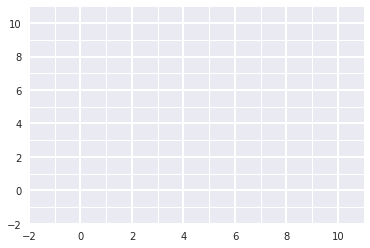

In [ ]:
fig,ax = plt.subplots()
camera = Camera(fig)
camera = particle_loop(camera, fig, odom, particles, noise)
animation = camera.animate()
HTML(animation.to_html5_video())

# Resampling Example

Now we will see how to perform the resampling process in the Particle Filter (without motion), and we will plot the results to compare the before and after of the particles sampled.

## Initialize particles (v2.0)

Initialize the particles by drawing around the point [0,0] with a gaussian distribution:

In [99]:
# Initialize values for particles
weights = np.ones(numParticles)*(1/numParticles)
mu, sigma = [0,0], [[1, 2],[2,1]] # mean and covariance
pose = np.random.multivariate_normal(mu, sigma, (numParticles)).tolist()
data = {'weights': weights,
        'pose': pose,
        'history': pose}
# Create dataframe
weighted_particles = pd.DataFrame(data)
weighted_particles

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


,weights,pose,history
0,0.01,"[-1.3738635200348845, -1.3712448033373144]","[-1.3738635200348845, -1.3712448033373144]"
1,0.01,"[0.5225817815597392, 1.419586195703402]","[0.5225817815597392, 1.419586195703402]"
2,0.01,"[0.29884370092391804, -0.7942308928606789]","[0.29884370092391804, -0.7942308928606789]"
3,0.01,"[-0.3973589865480111, -1.33083137165817]","[-0.3973589865480111, -1.33083137165817]"
4,0.01,"[-0.6940836093185238, -1.0913357792694376]","[-0.6940836093185238, -1.0913357792694376]"
...,...,...,...
95,0.01,"[-2.012058607522266, -0.40226017922681706]","[-2.012058607522266, -0.40226017922681706]"
96,0.01,"[-1.4474222416795348, -0.9775829712560558]","[-1.4474222416795348, -0.9775829712560558]"
97,0.01,"[0.6104504833595339, -0.7317081385188663]","[0.6104504833595339, -0.7317081385188663]"
98,0.01,"[-1.7475905719334364, 0.9844649623039279]","[-1.7475905719334364, 0.9844649623039279]"


Weight the particles according to their distance to [0 0]:

In [100]:
sig = np.diag([0.2,0.2], k= 0)
siginv = np.linalg.inv(sig)
weighted_particles.loc[:,'weights'] = weighted_particles.loc[:,'pose'].apply(lambda x: math.exp((-1/2)*float(np.matmul(np.matmul(np.reshape(np.asarray(x),(1,2)),siginv),np.reshape(np.asarray(x),(2,1)))))) 
weighted_particles

,weights,pose,history
0,0.000081,"[-1.3738635200348845, -1.3712448033373144]","[-1.3738635200348845, -1.3712448033373144]"
1,0.003277,"[0.5225817815597392, 1.419586195703402]","[0.5225817815597392, 1.419586195703402]"
2,0.165253,"[0.29884370092391804, -0.7942308928606789]","[0.29884370092391804, -0.7942308928606789]"
3,0.008047,"[-0.3973589865480111, -1.33083137165817]","[-0.3973589865480111, -1.33083137165817]"
4,0.015269,"[-0.6940836093185238, -1.0913357792694376]","[-0.6940836093185238, -1.0913357792694376]"
...,...,...,...
95,0.000027,"[-2.012058607522266, -0.40226017922681706]","[-2.012058607522266, -0.40226017922681706]"
96,0.000487,"[-1.4474222416795348, -0.9775829712560558]","[-1.4474222416795348, -0.9775829712560558]"
97,0.103300,"[0.6104504833595339, -0.7317081385188663]","[0.6104504833595339, -0.7317081385188663]"
98,0.000043,"[-1.7475905719334364, 0.9844649623039279]","[-1.7475905719334364, 0.9844649623039279]"


## Resample
The resampling process induces a loss of diversity in particle population, which manifests as an approximation error: even though the variance of the particle set itself decreases, the variance of the particle set as an estimator increases.

The "Low Variance Sampling", also called "Stochastic Universal Sampling" is an implementation that selects samples in a sequential stochastic process, instead of selecting them independently of each other. (Probabilistic Robotics, p.109).

We select a single random number, and then select the samples according to this number, but still with a probability proportional to the sample weight.

In [109]:
def low_variance_sampling(particles):
  numParticles = particles.shape[0]
  w = particles.loc[:,'weights']
  # normalize the weights
  w = w/np.sum(w)

  newParticles = pd.DataFrame({'weights' : [],'pose' : [],'history' : []}) 
  
  c = w[0]
  i = 0
  # Initialize the position of the sampling wheel
  r = random.uniform(0.,1/numParticles)
  # Move along the wheel to select particles
  for m in range (numParticles):
    U = r + (m-1) * (1/numParticles)
    while (U > c):
      i += 1
      c = c + w[i]

    newParticles = newParticles.append(particles.loc[i,:])


  return newParticles

In [110]:
resampled_particles = low_variance_sampling(weighted_particles)
resampled_particles

,weights,pose,history
0,0.000081,"[-1.3738635200348845, -1.3712448033373144]","[-1.3738635200348845, -1.3712448033373144]"
2,0.165253,"[0.29884370092391804, -0.7942308928606789]","[0.29884370092391804, -0.7942308928606789]"
2,0.165253,"[0.29884370092391804, -0.7942308928606789]","[0.29884370092391804, -0.7942308928606789]"
2,0.165253,"[0.29884370092391804, -0.7942308928606789]","[0.29884370092391804, -0.7942308928606789]"
5,0.083111,"[-0.4871946629272978, -0.8704435704202006]","[-0.4871946629272978, -0.8704435704202006]"
...,...,...,...
94,0.348348,"[0.38492802946209914, -0.5231176688437994]","[0.38492802946209914, -0.5231176688437994]"
94,0.348348,"[0.38492802946209914, -0.5231176688437994]","[0.38492802946209914, -0.5231176688437994]"
94,0.348348,"[0.38492802946209914, -0.5231176688437994]","[0.38492802946209914, -0.5231176688437994]"
94,0.348348,"[0.38492802946209914, -0.5231176688437994]","[0.38492802946209914, -0.5231176688437994]"


Plot particles before (red) and after (blue)

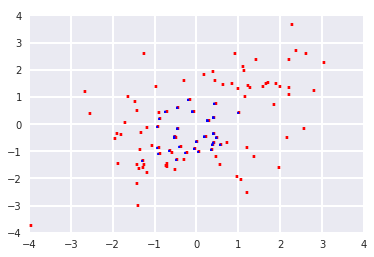

In [113]:
fig,ax = plt.subplots()
# visualize state of particles
ax.set_xticks([x for x in range(-4,5)],minor=True )
ax.set_yticks([y for y in range(-4,5)],minor=True)

# using seaborn, set background grid to gray
sns.set_style("dark")

# Plot grid on minor axes in gray (width = 1)
plt.grid(which='minor',ls='-',lw=1, color='white')

# Plot grid on major axes in larger width
plt.grid(which='major',ls='-',lw=2, color='white')

# Plot particles
for key, value in weighted_particles['pose'].iteritems():
  ax.text(value[0],value[1], '.', color = 'red', fontsize = 25)
for key, value in resampled_particles['pose'].iteritems():
  ax.text(value[0],value[1], '.', color = 'blue', fontsize = 20)

plt.show()